In [1]:
from init import *

In [2]:
from transformations import (train_transforms,test_transforms,no_transforms)
from trainer import Trainer
from tester import Tester
from utlis import visualize_data,show_misclassified_images,device,is_cuda
from viz import plot_class_distribution, plot_confusion_matrix, plot_curves
from dataloader import CIFAR10Dataset,CIFAR10DataLoader
from models import ConvLayer,TransBlock,DepthwiseConvLayer

In [3]:
# Augmentation
atrain_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=train_transforms,download=False)
atest_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
acifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
atrain_loader, atest_loader = acifar.get_loader(atrain_dataset,atest_dataset)


# No Augmentation
train_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=test_transforms,download=False)
test_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
cifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
train_loader, test_loader = cifar.get_loader(train_dataset,test_dataset)

In [4]:
# torch.cuda.amp.autocast(enabled=True, dtype=torch.float16, cache_enabled=False)

C:\Users\muthu\Documents\TSAI\session 9\utlis.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


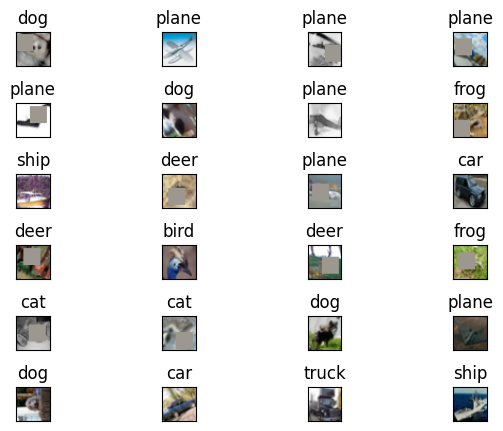

In [5]:
visualize_data(atrain_loader,classes=acifar.classes,num_figures=24)

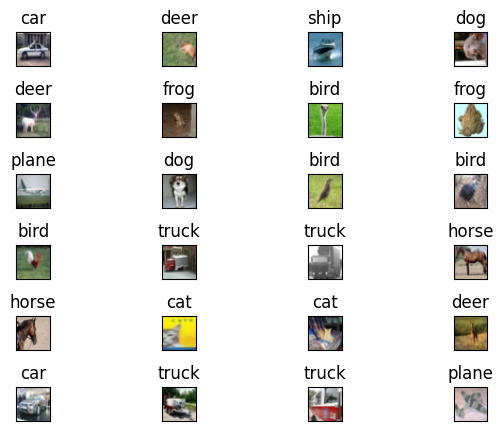

In [6]:
visualize_data(train_loader,classes=acifar.classes,num_figures=24)

In [7]:
dp_rate = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = ConvLayer(inc=3,outc=8,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        
        self.conv2 = ConvLayer(         inc=8,outc=16,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep2  = DepthwiseConvLayer(inc=8,outc=16,p=1,s=1,dp_rate=dp_rate)
        self.dil2  = ConvLayer(         inc=8,outc=16,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.conv3 = ConvLayer(         inc=16,outc=32,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep3  = DepthwiseConvLayer(inc=16,outc=32,p=1,s=1,dp_rate=dp_rate)
        self.dil3  = ConvLayer(         inc=16,outc=32,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.trans4 = TransBlock(56,16,p=0,s=2)


        self.conv5 = ConvLayer(16,32,k=3,p=1,s=1,d=1,dp_rate=dp_rate)

        self.conv6 = ConvLayer(         inc=32,outc=48,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep6  = DepthwiseConvLayer(inc=32,outc=48,p=1,s=1,dp_rate=dp_rate)
        self.dil6  = ConvLayer(         inc=32,outc=48,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.conv7 = ConvLayer(         inc=48,outc=56,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep7  = DepthwiseConvLayer(inc=48,outc=56,p=1,s=1,dp_rate=dp_rate)
        self.dil7  = ConvLayer(         inc=48,outc=56,k=3,p=2,s=1,d=2,dp_rate=dp_rate)
      
        self.trans8 = TransBlock(136,24,p=0,s=2)

        
        self.conv9 = ConvLayer(24,40,k=3,p=1,s=1,d=1,dp_rate=dp_rate)

        self.conv10 = ConvLayer(         inc=40,outc=48,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep10  = DepthwiseConvLayer(inc=40,outc=48,p=1,s=1,dp_rate=dp_rate)
        self.dil10  = ConvLayer(         inc=40,outc=48,k=3,p=4,s=1,d=4,dp_rate=dp_rate)


        self.conv_ = ConvLayer(         inc=48,outc=48,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep_  = DepthwiseConvLayer(inc=48,outc=48,p=1,s=1,dp_rate=dp_rate)
        self.dil_  = ConvLayer(         inc=48,outc=48,k=3,p=4,s=1,d=4,dp_rate=dp_rate)

        self.trans11 = TransBlock(88,40,p=0,s=1)
        self.trans12 = TransBlock(40,20,p=0,s=1)
        self.out = TransBlock(inc=20,outc=10,p=0,s=1)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        
    
    def forward(self,x):  
        x0 = self.conv1(x)
        x1 = self.dep2(x0) + self.conv2(x0) + self.dil2(x0) 
        x2 = self.dep3(x1) + self.conv3(x1) + self.dil3(x1) 
        x3 = torch.concat((x0,x1,x2),dim=1)
        x4 = self.trans4(x3)

        x5 = self.conv5(x4)
        x6 = self.conv6(x5) + self.dep6(x5) + self.dil6(x5)
        x7 = self.conv7(x6)+ self.dep7(x6)+ self.dil7(x6)
        x8 = torch.concat((x5,x6,x7),dim=1)
        x9  = self.trans8(x8)

        x10 = self.conv9(x9)
        x11 = self.conv10(x10) + self.dep10(x10) + self.dil10(x10)
        x11 = self.conv_(x11) + self.dep_(x11) + self.dil_(x11)
        x12 = torch.concat((x10,x11),dim=1)
        x  = self.trans11(x12)
        x  = self.trans12(x)
        
        x = self.out(x)
        x = self.gap(x)
        return  F.log_softmax(x.view(-1,10), dim=1)


model = Net().to(device=device)
summary(model,input_size=(1,3,32,32),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─ConvLayer: 1-1                         [1, 8, 32, 32]            --
│    └─Sequential: 2-1                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-1                  [1, 8, 32, 32]            216
│    │    └─BatchNorm2d: 3-2             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-3                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-4               [1, 8, 32, 32]            --
├─DepthwiseConvLayer: 1-2                [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 8, 32, 32]            72
│    │    └─Conv2d: 3-6                  [1, 16, 32, 32]           128
│    │    └─ReLU: 3-7                    [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-8             [1, 16, 32, 32]           32
│    │    └─D

In [8]:
prev_test_loss = float('inf')

optimizer = optim.SGD(params=model.parameters(), lr=0.15, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model, test_loader=test_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        state = { 'epoch': epoch,'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        torch.save(obj=state,f='./bmodels/bmodel.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.15 | Loss = 1.54 | Batch = 97 | Accuracy = 33.02: 100%|██| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.0032, Accuracy: 4230/10000 (42.30%)


EPOCH = 2 | LR = 0.15 | Loss = 1.32 | Batch = 97 | Accuracy = 46.39: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0028, Accuracy: 4817/10000 (48.17%)


EPOCH = 3 | LR = 0.15 | Loss = 1.18 | Batch = 97 | Accuracy = 53.54: 100%|██| 98/98 [00:41<00:00,  2.38it/s]


Test set: Average loss: 0.0022, Accuracy: 6062/10000 (60.62%)


EPOCH = 4 | LR = 0.15 | Loss = 1.06 | Batch = 97 | Accuracy = 59.82: 100%|██| 98/98 [00:41<00:00,  2.37it/s]


Test set: Average loss: 0.0019, Accuracy: 6613/10000 (66.13%)


EPOCH = 5 | LR = 0.15 | Loss = 1.10 | Batch = 97 | Accuracy = 63.44: 100%|██| 98/98 [00:41<00:00,  2.38it/s]


Test set: Average loss: 0.0018, Accuracy: 6680/10000 (66.80%)


EPOCH = 6 | LR = 0.15 | Loss = 0.84 | Batch = 97 | Accuracy = 66.15: 100%|██| 98/98 [00:41<00:00,  2.38it/s]


Test set: Average loss: 0.0018, Accuracy: 6840/10000 (68.40%)


EPOCH = 7 | LR = 0.15 | Loss = 0.88 | Batch = 97 | Accuracy = 68.48: 100%|██| 98/98 [00:41<00:00,  2.37it/s]


Test set: Average loss: 0.0016, Accuracy: 7255/10000 (72.55%)


EPOCH = 8 | LR = 0.15 | Loss = 0.93 | Batch = 97 | Accuracy = 70.30: 100%|██| 98/98 [00:41<00:00,  2.34it/s]


Test set: Average loss: 0.0016, Accuracy: 7245/10000 (72.45%)


EPOCH = 9 | LR = 0.15 | Loss = 0.85 | Batch = 97 | Accuracy = 71.87: 100%|██| 98/98 [00:42<00:00,  2.30it/s]


Test set: Average loss: 0.0015, Accuracy: 7377/10000 (73.77%)


EPOCH = 10 | LR = 0.15 | Loss = 0.85 | Batch = 97 | Accuracy = 73.17: 100%|█| 98/98 [00:41<00:00,  2.37it/s]


Test set: Average loss: 0.0014, Accuracy: 7560/10000 (75.60%)


EPOCH = 11 | LR = 0.15 | Loss = 0.81 | Batch = 97 | Accuracy = 74.31: 100%|█| 98/98 [00:41<00:00,  2.38it/s]


Test set: Average loss: 0.0014, Accuracy: 7668/10000 (76.68%)


EPOCH = 12 | LR = 0.15 | Loss = 0.77 | Batch = 97 | Accuracy = 75.32: 100%|█| 98/98 [00:41<00:00,  2.39it/s]


Test set: Average loss: 0.0014, Accuracy: 7614/10000 (76.14%)


EPOCH = 13 | LR = 0.15 | Loss = 0.82 | Batch = 97 | Accuracy = 76.14: 100%|█| 98/98 [00:41<00:00,  2.37it/s]


Test set: Average loss: 0.0015, Accuracy: 7474/10000 (74.74%)


EPOCH = 14 | LR = 0.15 | Loss = 0.73 | Batch = 97 | Accuracy = 76.75: 100%|█| 98/98 [00:41<00:00,  2.37it/s]


Test set: Average loss: 0.0013, Accuracy: 7790/10000 (77.90%)


EPOCH = 15 | LR = 0.15 | Loss = 0.58 | Batch = 97 | Accuracy = 77.39: 100%|█| 98/98 [00:40<00:00,  2.44it/s]


Test set: Average loss: 0.0013, Accuracy: 7788/10000 (77.88%)


EPOCH = 16 | LR = 0.15 | Loss = 0.63 | Batch = 97 | Accuracy = 78.11: 100%|█| 98/98 [00:39<00:00,  2.45it/s]


Test set: Average loss: 0.0013, Accuracy: 7805/10000 (78.05%)


EPOCH = 17 | LR = 0.15 | Loss = 0.65 | Batch = 97 | Accuracy = 78.75: 100%|█| 98/98 [00:39<00:00,  2.46it/s]


Test set: Average loss: 0.0012, Accuracy: 7874/10000 (78.74%)


EPOCH = 18 | LR = 0.15 | Loss = 0.53 | Batch = 97 | Accuracy = 79.30: 100%|█| 98/98 [00:40<00:00,  2.44it/s]


Test set: Average loss: 0.0012, Accuracy: 7961/10000 (79.61%)


EPOCH = 19 | LR = 0.15 | Loss = 0.65 | Batch = 97 | Accuracy = 79.80: 100%|█| 98/98 [00:40<00:00,  2.44it/s]


Test set: Average loss: 0.0012, Accuracy: 7919/10000 (79.19%)


EPOCH = 20 | LR = 0.15 | Loss = 0.59 | Batch = 97 | Accuracy = 80.14: 100%|█| 98/98 [00:40<00:00,  2.44it/s]


Test set: Average loss: 0.0012, Accuracy: 7962/10000 (79.62%)


EPOCH = 21 | LR = 0.15 | Loss = 0.57 | Batch = 97 | Accuracy = 80.55: 100%|█| 98/98 [00:39<00:00,  2.45it/s]


Test set: Average loss: 0.0012, Accuracy: 7996/10000 (79.96%)


EPOCH = 22 | LR = 0.15 | Loss = 0.60 | Batch = 97 | Accuracy = 81.08: 100%|█| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0012, Accuracy: 8017/10000 (80.17%)


EPOCH = 23 | LR = 0.15 | Loss = 0.61 | Batch = 97 | Accuracy = 81.49: 100%|█| 98/98 [00:42<00:00,  2.31it/s]


Test set: Average loss: 0.0012, Accuracy: 8016/10000 (80.16%)


EPOCH = 24 | LR = 0.15 | Loss = 0.69 | Batch = 97 | Accuracy = 81.62: 100%|█| 98/98 [00:44<00:00,  2.20it/s]


Test set: Average loss: 0.0011, Accuracy: 8099/10000 (80.99%)


EPOCH = 25 | LR = 0.15 | Loss = 0.58 | Batch = 97 | Accuracy = 81.67: 100%|█| 98/98 [00:43<00:00,  2.24it/s]


Test set: Average loss: 0.0012, Accuracy: 7991/10000 (79.91%)


EPOCH = 26 | LR = 0.15 | Loss = 0.44 | Batch = 97 | Accuracy = 82.35: 100%|█| 98/98 [00:42<00:00,  2.29it/s]


Test set: Average loss: 0.0012, Accuracy: 8015/10000 (80.15%)


EPOCH = 27 | LR = 0.15 | Loss = 0.45 | Batch = 97 | Accuracy = 82.82: 100%|█| 98/98 [00:42<00:00,  2.29it/s]


Test set: Average loss: 0.0012, Accuracy: 8081/10000 (80.81%)


EPOCH = 28 | LR = 0.15 | Loss = 0.52 | Batch = 97 | Accuracy = 82.89: 100%|█| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0011, Accuracy: 8109/10000 (81.09%)


EPOCH = 29 | LR = 0.015 | Loss = 0.36 | Batch = 97 | Accuracy = 85.43: 100%|█| 98/98 [00:40<00:00,  2.41it/s


Test set: Average loss: 0.0011, Accuracy: 8267/10000 (82.67%)


EPOCH = 30 | LR = 0.015 | Loss = 0.39 | Batch = 97 | Accuracy = 86.03: 100%|█| 98/98 [00:40<00:00,  2.43it/s


Test set: Average loss: 0.0011, Accuracy: 8299/10000 (82.99%)


EPOCH = 31 | LR = 0.015 | Loss = 0.35 | Batch = 97 | Accuracy = 86.28: 100%|█| 98/98 [00:40<00:00,  2.40it/s


Test set: Average loss: 0.0010, Accuracy: 8293/10000 (82.93%)


EPOCH = 32 | LR = 0.015 | Loss = 0.41 | Batch = 97 | Accuracy = 86.52: 100%|█| 98/98 [00:42<00:00,  2.32it/s


Test set: Average loss: 0.0011, Accuracy: 8295/10000 (82.95%)


EPOCH = 33 | LR = 0.015 | Loss = 0.41 | Batch = 97 | Accuracy = 86.91: 100%|█| 98/98 [00:40<00:00,  2.42it/s


Test set: Average loss: 0.0011, Accuracy: 8283/10000 (82.83%)


EPOCH = 34 | LR = 0.015 | Loss = 0.30 | Batch = 97 | Accuracy = 86.89: 100%|█| 98/98 [00:41<00:00,  2.36it/s


Test set: Average loss: 0.0011, Accuracy: 8308/10000 (83.08%)


EPOCH = 35 | LR = 0.015 | Loss = 0.33 | Batch = 97 | Accuracy = 87.01: 100%|█| 98/98 [00:40<00:00,  2.42it/s


Test set: Average loss: 0.0011, Accuracy: 8309/10000 (83.09%)


EPOCH = 36 | LR = 0.0015 | Loss = 0.32 | Batch = 97 | Accuracy = 87.36: 100%|█| 98/98 [00:41<00:00,  2.36it/


Test set: Average loss: 0.0011, Accuracy: 8299/10000 (82.99%)


EPOCH = 37 | LR = 0.0015 | Loss = 0.39 | Batch = 97 | Accuracy = 87.40: 100%|█| 98/98 [00:42<00:00,  2.31it/


Test set: Average loss: 0.0011, Accuracy: 8298/10000 (82.98%)


EPOCH = 38 | LR = 0.0015 | Loss = 0.38 | Batch = 97 | Accuracy = 87.44: 100%|█| 98/98 [00:40<00:00,  2.42it/


Test set: Average loss: 0.0011, Accuracy: 8314/10000 (83.14%)


EPOCH = 39 | LR = 0.0015 | Loss = 0.31 | Batch = 97 | Accuracy = 87.33: 100%|█| 98/98 [00:41<00:00,  2.37it/


Test set: Average loss: 0.0011, Accuracy: 8312/10000 (83.12%)


EPOCH = 40 | LR = 0.00015000000000000001 | Loss = 0.33 | Batch = 97 | Accuracy = 87.41: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0011, Accuracy: 8308/10000 (83.08%)


EPOCH = 41 | LR = 0.00015000000000000001 | Loss = 0.38 | Batch = 97 | Accuracy = 87.30: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0011, Accuracy: 8303/10000 (83.03%)


EPOCH = 42 | LR = 0.00015000000000000001 | Loss = 0.39 | Batch = 97 | Accuracy = 87.10: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0011, Accuracy: 8311/10000 (83.11%)


EPOCH = 43 | LR = 0.00015000000000000001 | Loss = 0.43 | Batch = 97 | Accuracy = 87.24: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0011, Accuracy: 8307/10000 (83.07%)


EPOCH = 44 | LR = 1.5000000000000002e-05 | Loss = 0.38 | Batch = 97 | Accuracy = 87.51: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0011, Accuracy: 8313/10000 (83.13%)


EPOCH = 45 | LR = 1.5000000000000002e-05 | Loss = 0.30 | Batch = 97 | Accuracy = 87.47: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0011, Accuracy: 8307/10000 (83.07%)


EPOCH = 46 | LR = 1.5000000000000002e-05 | Loss = 0.35 | Batch = 97 | Accuracy = 87.35: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0011, Accuracy: 8301/10000 (83.01%)


EPOCH = 47 | LR = 1.5000000000000002e-05 | Loss = 0.35 | Batch = 97 | Accuracy = 87.38: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0011, Accuracy: 8315/10000 (83.15%)


EPOCH = 48 | LR = 1.5000000000000002e-06 | Loss = 0.35 | Batch = 97 | Accuracy = 87.39: 100%|█| 98/98 [00:41


Test set: Average loss: 0.0011, Accuracy: 8312/10000 (83.12%)


EPOCH = 49 | LR = 1.5000000000000002e-06 | Loss = 0.28 | Batch = 97 | Accuracy = 87.59: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0011, Accuracy: 8305/10000 (83.05%)


EPOCH = 50 | LR = 1.5000000000000002e-06 | Loss = 0.35 | Batch = 97 | Accuracy = 87.47: 100%|█| 98/98 [00:40


Test set: Average loss: 0.0011, Accuracy: 8303/10000 (83.03%)


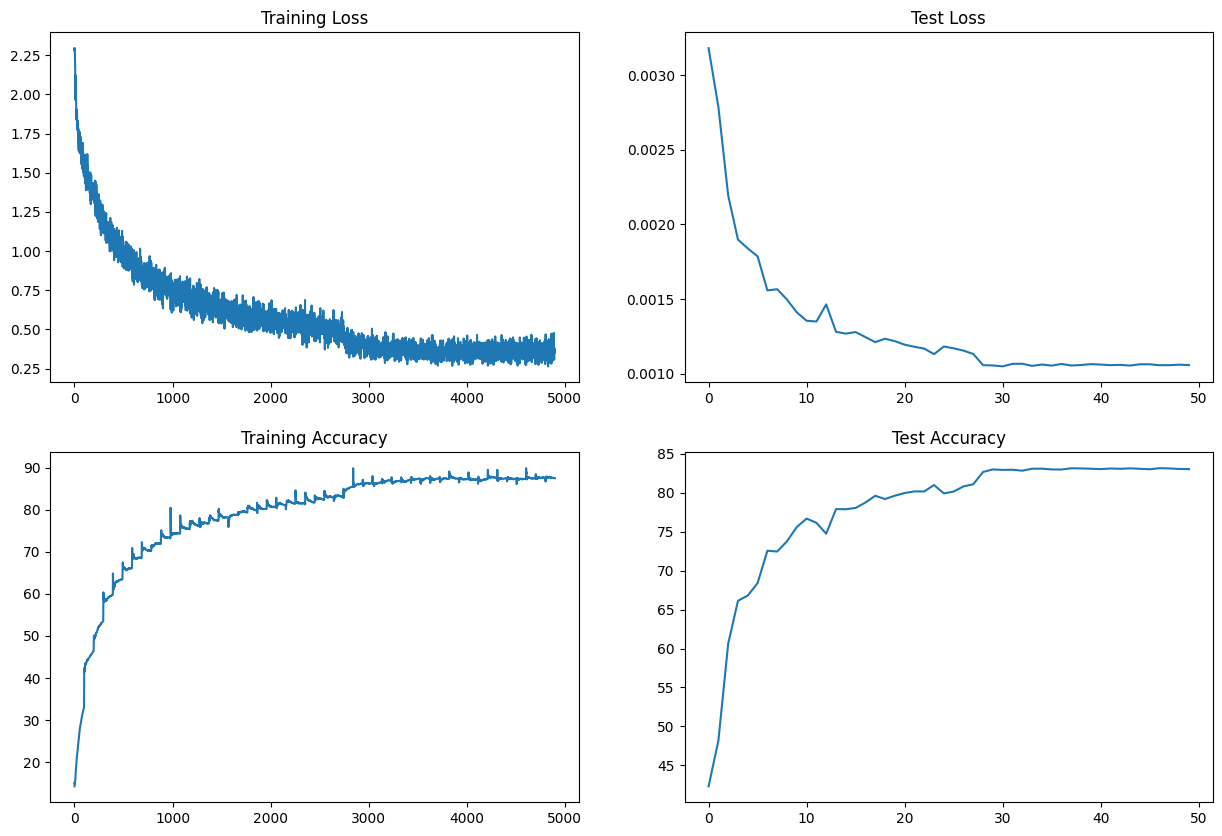

In [9]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

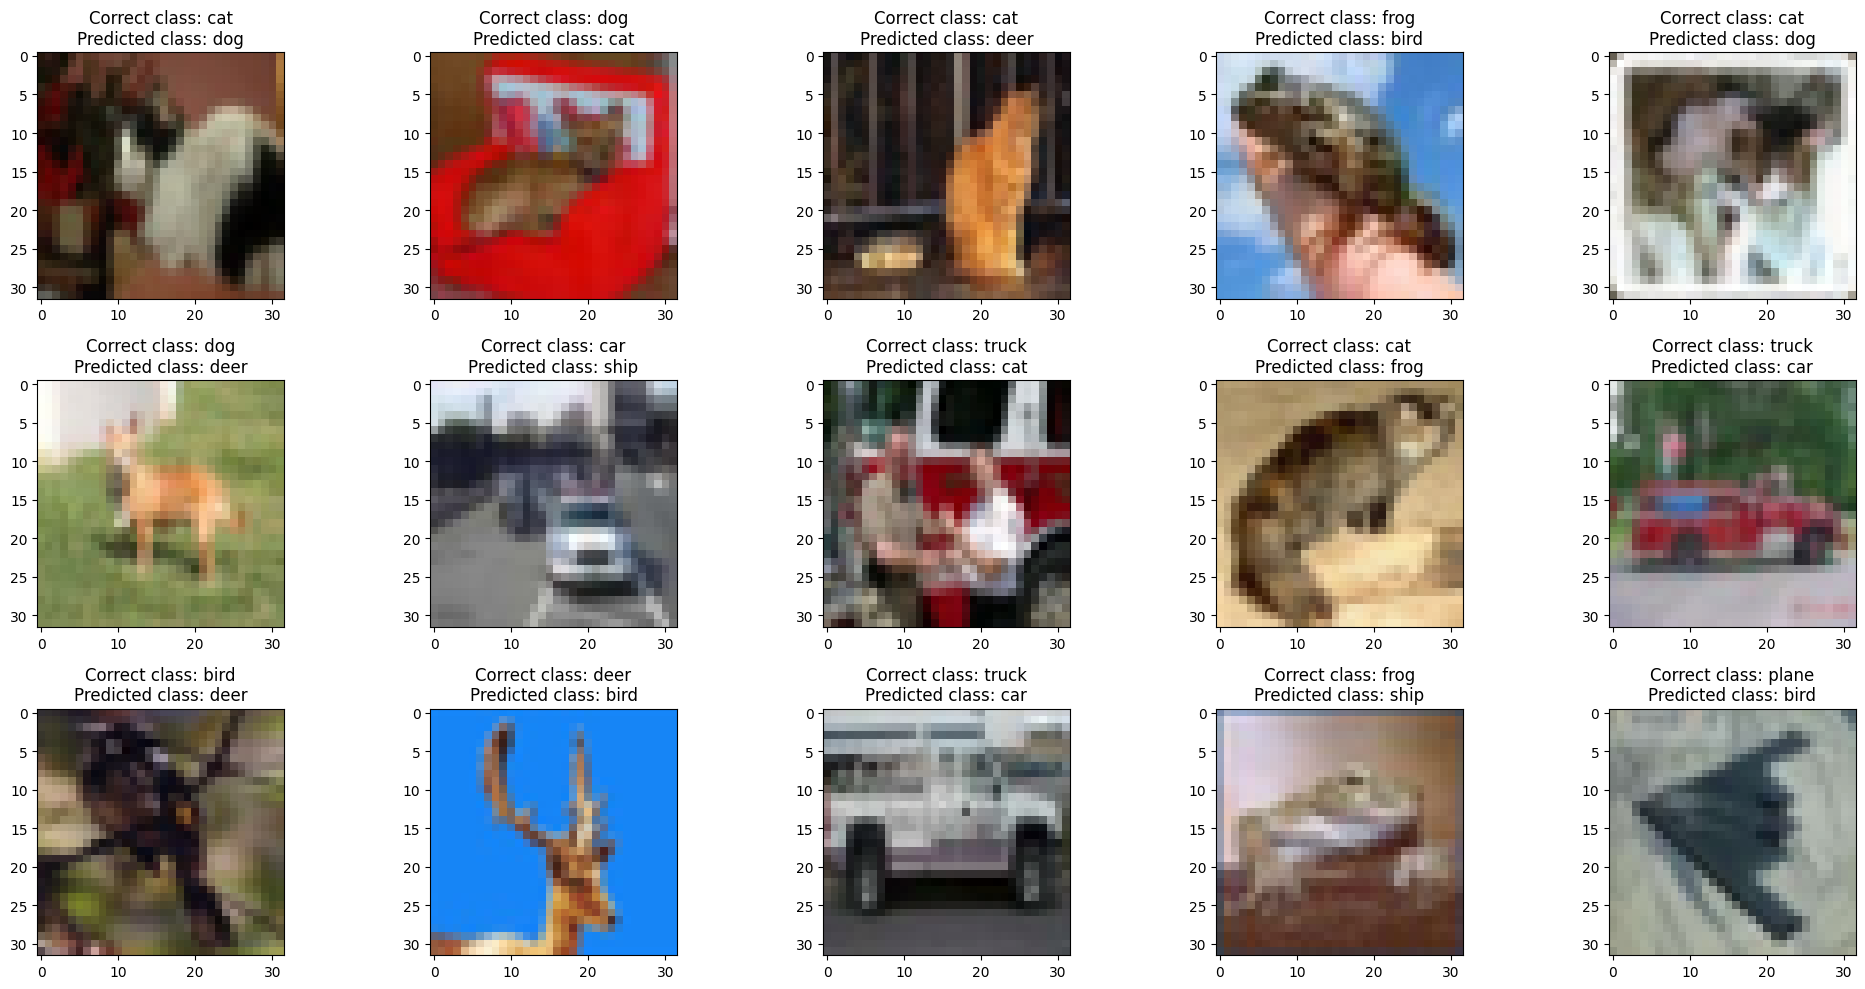

In [10]:
images, predictions, labels =  tester.get_misclassified_images()
show_misclassified_images(images[:15],predictions[:15],labels[:15],cifar.classes)

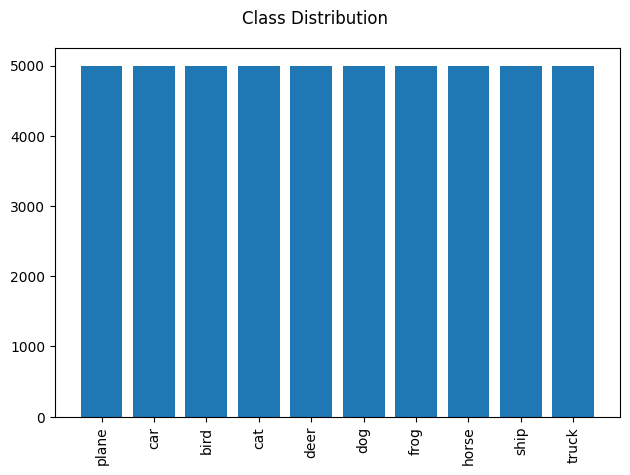

In [11]:
plot_class_distribution(train_loader,cifar.classes)

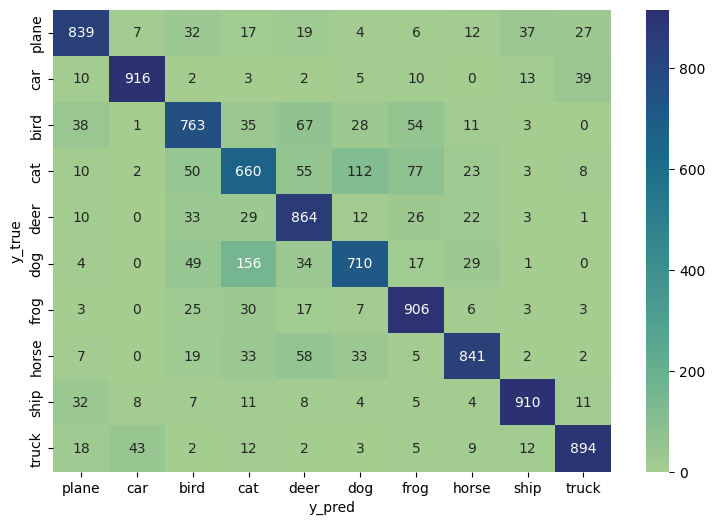

In [12]:
plot_confusion_matrix(model,test_loader,device,cifar.classes)

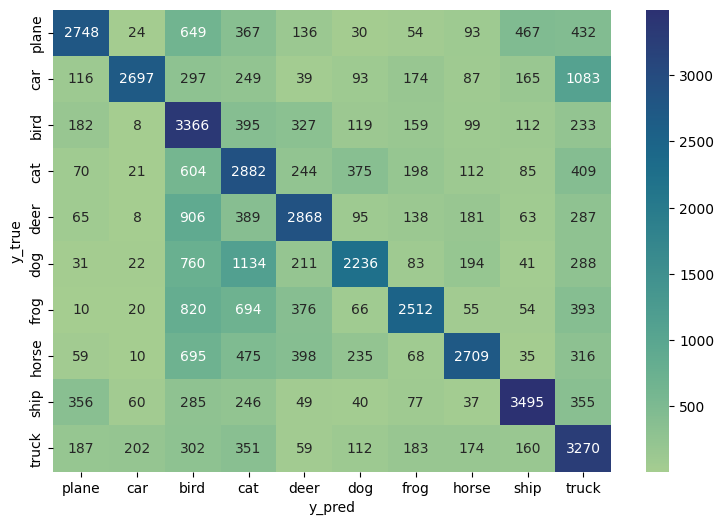

In [13]:
plot_confusion_matrix(model,atrain_loader,device,cifar.classes)